In [14]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Constants
M = 300.0  # Mass of vehicle (kg)
G = 9.81  # Acceleration due to gravity (m/s^2)
C_R1 = 0.004  # Rolling resistance coefficient 1
C_R2 = 0.052  # Rolling resistance coefficient 2
C_D = 0.13  # Drag coefficient
A_DRAG = 1.357  # Cross-sectional area (m^2)
P = 1.293  # Air density (kg/m^3)
N = 0.16  # Efficiency of solar panel (%)
A_SOLAR = 4.0  # Area of solar panel (m^2)
BAT_CAPACITY = 40 * 3.63 * 36 * 3600  # Pack capacity (J)
DISC = 3600 

# ETL & Utils
def map_distance_to_id(route_model_df, stage_name, distance):
    closest_row = route_model_df.iloc[(route_model_df['distance'] - distance).abs().idxmin()]
    return closest_row

# Power (In/Out)
def rolling_resistance(v):
    return (M * G * C_R1 + 4 * C_R2 * v) * v

def drag_resistance(v):
    return 0.5 * P * C_D * A_DRAG * v ** 3

def solar_power(G):
    return A_SOLAR * G * N

def sim(velocities):

    velocities = jnp.array(velocities)
    capacities = jnp.zeros(DISC)

    def step(i, carry):
        v, capacity, capacities = carry
        v = velocities[i]
        # could do: carry 'distance' as well and integrate here... 
        # maybe important if irradiance changes w/r/t distance... 
        solar_power_val = solar_power(0)  # Assuming G is zero here for simplicity (you can modify as needed)
        rolling_resistance_val = rolling_resistance(v)
        drag_resistance_val = drag_resistance(v)
        capacity = capacity + solar_power_val - rolling_resistance_val - drag_resistance_val # simplified scenario, shouldn't be too hard to add others
        capacities = capacities.at[i].set(capacity)
        return (v, capacity, capacities)

    initial_capacity = BAT_CAPACITY
    v_final, capacity_final, capacities = jax.lax.fori_loop(0, DISC, step, (velocities[0], initial_capacity, capacities))
    
    # final_capacity = capacity_values[-1] / 3600  # Convert from Joules to Wh
    return capacities  # Assuming you want to minimize/maximize this value

def cost_func(velocities):
    capacities = sim(velocities)

    # for cost, integrate velocities... 
    dist = jnp.sum(velocities) 
    final_capacity = capacities[-1]

    dist_weight = 1 
    cap_weight = 2 

    weighted = - dist * dist_weight + final_capacity * cap_weight
    return weighted

# jax.grad will take the gradient *wrt* the first arg of the provided function... 
grad_func = jax.grad(cost_func)

# Simulation parameters
DISC = 3600  # Time intervals (seconds)
STAGE_SYMBOL = "1B"  # Stage
CURRENT_D = 0e3  # Starting distance (m)
velocities = jnp.full(DISC, 10.0)  # Sample velocity profile

# Run Sim
capacities = sim(velocities)
grad = grad_func(velocities)

# ... 
print(capacities)
print(cost_func(velocities))
print(grad) 


[18817668. 18817416. 18817164. ... 17911224. 17910972. 17910720.]
35785440.0
[-101.29344 -101.29344 -101.29344 ... -101.29344 -101.29344 -101.29344]


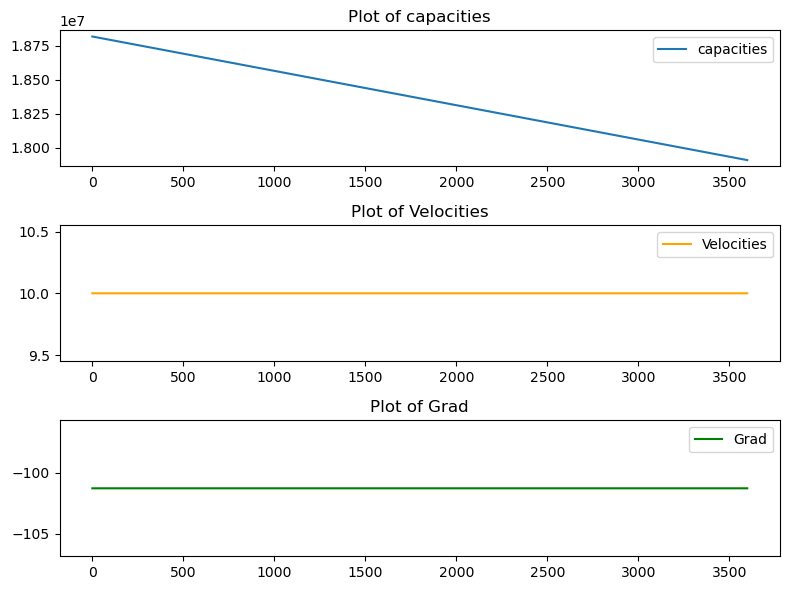

In [15]:
# Create a figure and subplots (2 rows, 1 column)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))

# Plot sim_data on the first subplot
ax1.plot(capacities, label="capacities")
ax1.set_title("Plot of capacities")
ax1.legend()

# Plot velocities on the second subplot
ax2.plot(velocities, label="Velocities", color="orange")
ax2.set_title("Plot of Velocities")
ax2.legend()

ax3.plot(grad, label="Grad", color="green")
ax3.set_title("Plot of Grad")
ax3.legend()

# Adjust layout to prevent overlapping
fig.tight_layout()